In [1]:
import sys
import numpy as np
import xarray as xr
import dask.array as da
import numpy.ma as ma
from netCDF4 import Dataset

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm

import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import cartopy

from decimal import Decimal

%matplotlib inline

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask.dataframe as dd
import dask


In [3]:
cluster = PBSCluster(
    cores=1,
    memory="120GB",
    project='pangeo',
    processes=1,
    walltime='00:30:00',
    local_directory='$TMPDIR')
cluster

In [4]:
cluster.scale(20)

In [5]:
client = Client(cluster) # scheduler_file="/home/ad/briolf/scheduler.json")
client

Client Scheduler: tcp://10.120.40.134:42814 Dashboard: http://10.120.40.134:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
!qstat -u albert7a

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 10:
        break
    time.sleep(1)
print(nb_workers)

15


In [7]:
ds_amp=xr.open_dataset('/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60-BLBT02_tidal_amp_y2009m07-y2010m06.nc',chunks={'X':1000,'Y':1000})
ds_phase=xr.open_dataset('/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60-BLBT02_tidal_phase_y2009m07-y2010m06.nc',chunks={'X':1000,'Y':1000})    

In [8]:
ds_grid=xr.open_dataset('/work/ALT/odatis/eNATL60/mesh_mask_eNATL60_3.6_lev1.nc4',chunks={'x':1000,'y':1000})

In [9]:
navlat=ds_grid.nav_lat
navlon=ds_grid.nav_lon
tmask=ds_grid.tmask[0]

In [10]:
amp=ds_amp['tidal-amp'][0]
amp_mask=ma.masked_where(tmask==0.,amp)
ph=(180/np.pi)*ds_phase['tidal-phase'][0]
ph360=da.where(ph<0,ph+360,ph)
ph360_mask=ma.masked_where(tmask==0.,ph360)

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


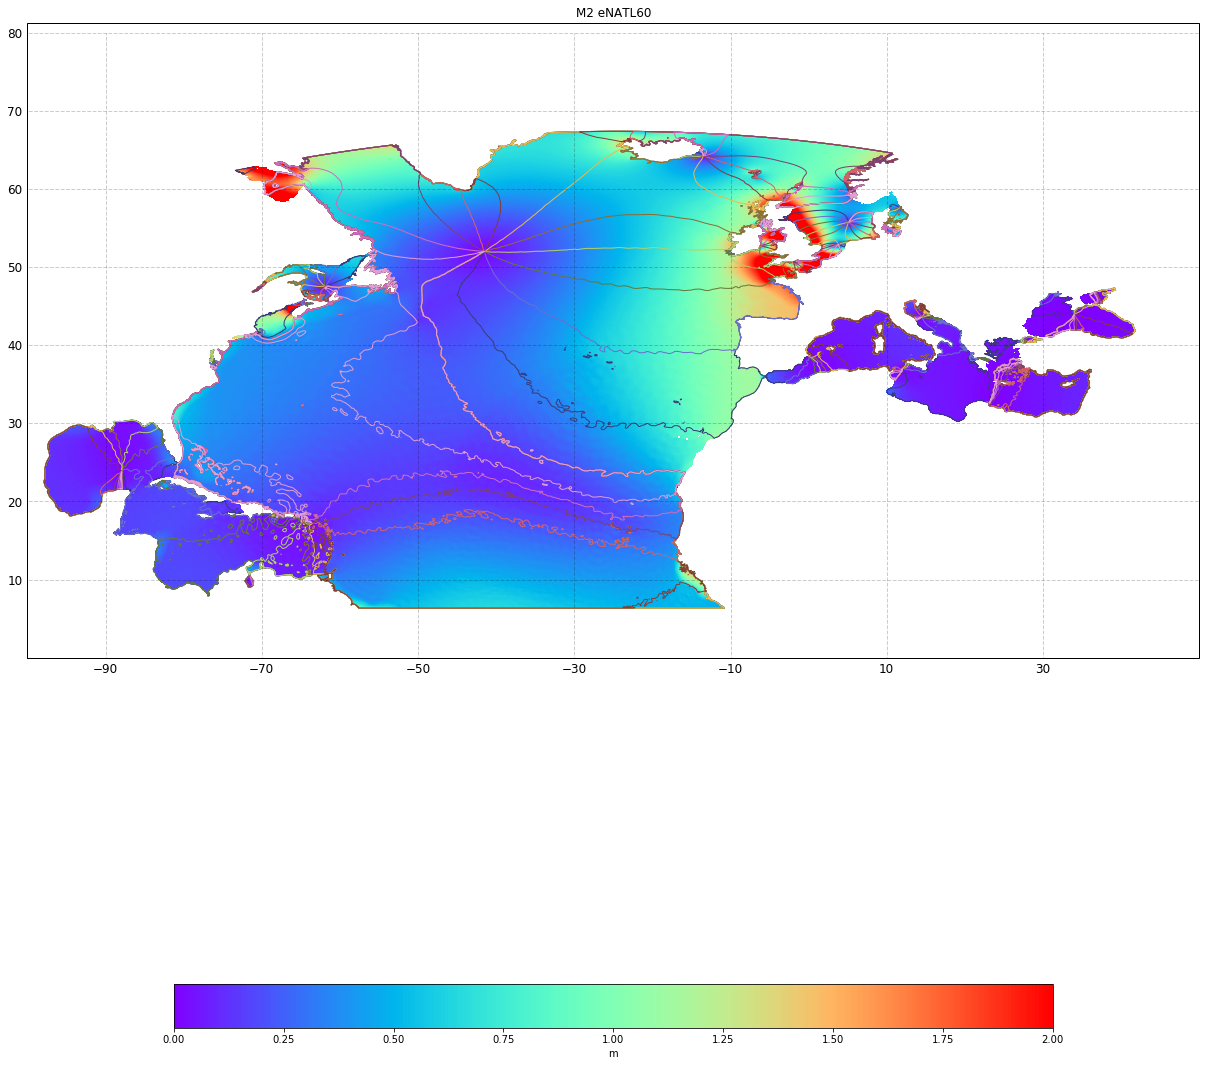

In [11]:
cmap=plt.get_cmap('rainbow')
matplotlib.rcParams['contour.negative_linestyle']= 'solid'
matplotlib.rcParams['lines.linewidth']= 2

fig=plt.figure(figsize=(21,40))
pj= ccrs.PlateCarree()
ax=plt.subplot(1,1,1,projection=pj)

#ax.coastlines(resolution="10m")
ax.set_extent([-100,50,0,60])

gl = ax.gridlines(crs=pj, draw_labels=True, linewidth=1, color='black', alpha=0.2, linestyle='--')
label_style= {'size' : 12, 'color' : 'black'}
gl.xlabel_style = label_style
gl.xlabels_top = False
gl.xlocator = mticker.FixedLocator(np.arange(-110,100,20,dtype=float))
gl.ylabel_style = label_style
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator(np.arange(-20,90,10,dtype=float))
cs = plt.pcolormesh(navlon,navlat,amp_mask,transform=ccrs.PlateCarree(),cmap=cmap,vmin=0,vmax=2)
plt.contour(navlon,navlat,ph360,[30,60,90,120,150,180,210,240,270,300,330],cmap=plt.get_cmap('tab20b'),linestyle='solid',linewidths=1,transform=ccrs.PlateCarree())
plt.title('M2 eNATL60')
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.75,label='m')
